# Day 7: Week 10 Review - Time Series Models

## 🎯 Learning Objectives
- Review all time series methods
- Compare forecasting approaches
- Build ensemble prediction system

---

## 📚 Week Summary

| Day | Topic | Key Concept |
|-----|-------|-------------|
| 1 | ARIMA | AR + Differencing + MA |
| 2 | GARCH | Volatility modeling |
| 3 | VAR | Multivariate forecasting |
| 4 | Cointegration | Pairs trading |
| 5 | Kalman Filter | Dynamic estimation |
| 6 | Regime Switching | Hidden states |

---

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


In [13]:
# Split data
train_size = int(len(returns) * 0.8)
train_ret = returns.iloc[:train_size]
test_ret = returns.iloc[train_size:]

print(f"\nTrain: {len(train_ret)} days")
print(f"Test: {len(test_ret)} days")


Train: 1002 days
Test: 251 days


In [14]:
# Model 1: ARIMA
print("\n🔄 Fitting ARIMA...")
arima_preds = []
history = list(train_ret.values)

for t in range(len(test_ret)):
    model = ARIMA(history, order=(1, 0, 1))
    fitted = model.fit()
    pred = fitted.forecast(steps=1)[0]
    arima_preds.append(pred)
    history.append(test_ret.iloc[t])

arima_preds = pd.Series(arima_preds, index=test_ret.index)
print("✅ ARIMA complete")


🔄 Fitting ARIMA...
✅ ARIMA complete


In [15]:
# Model 2: GARCH volatility forecast
print("\n🔄 Fitting GARCH...")
garch_vol = []
history_pct = list(train_ret.values * 100)

for t in range(len(test_ret)):
    model = arch_model(history_pct, vol='Garch', p=1, q=1)
    fitted = model.fit(disp='off')
    forecast = fitted.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.iloc[-1].values[0])
    garch_vol.append(vol / 100)  # Back to decimal
    history_pct.append(test_ret.iloc[t] * 100)

garch_vol = pd.Series(garch_vol, index=test_ret.index)
print("✅ GARCH complete")


🔄 Fitting GARCH...
✅ GARCH complete


In [16]:
# Model 3: Simple momentum (as baseline)
momentum_window = 20
momentum_preds = returns.rolling(momentum_window).mean().iloc[train_size:]
print("✅ Momentum baseline complete")

✅ Momentum baseline complete


In [17]:
# Build ensemble strategy
df = pd.DataFrame(index=test_ret.index)
df['actual'] = test_ret.values
df['arima_pred'] = arima_preds.values
df['momentum_pred'] = momentum_preds.values
df['garch_vol'] = garch_vol.values

# Signals
df['arima_signal'] = np.sign(df['arima_pred'])
df['momentum_signal'] = np.sign(df['momentum_pred'])

# Ensemble: average signal, scale by inverse volatility
df['ensemble_signal'] = (df['arima_signal'] + df['momentum_signal']) / 2
df['ensemble_signal'] = np.sign(df['ensemble_signal'])  # Discretize

# Vol-scaled position
target_vol = 0.15 / np.sqrt(TRADING_DAYS)  # 15% annualized
df['position_size'] = target_vol / df['garch_vol']
df['position_size'] = df['position_size'].clip(0.5, 2)  # 0.5x to 2x

df = df.dropna()

In [18]:
# Calculate returns for each strategy
df['arima_return'] = df['arima_signal'].shift(1) * df['actual']
df['momentum_return'] = df['momentum_signal'].shift(1) * df['actual']
df['ensemble_return'] = df['ensemble_signal'].shift(1) * df['actual']
df['ensemble_volscaled_return'] = df['ensemble_signal'].shift(1) * df['position_size'].shift(1) * df['actual']

df = df.dropna()

# Cumulative returns
df['buy_hold_cum'] = (1 + df['actual']).cumprod()
df['arima_cum'] = (1 + df['arima_return']).cumprod()
df['momentum_cum'] = (1 + df['momentum_return']).cumprod()
df['ensemble_cum'] = (1 + df['ensemble_return']).cumprod()
df['ensemble_vol_cum'] = (1 + df['ensemble_volscaled_return']).cumprod()

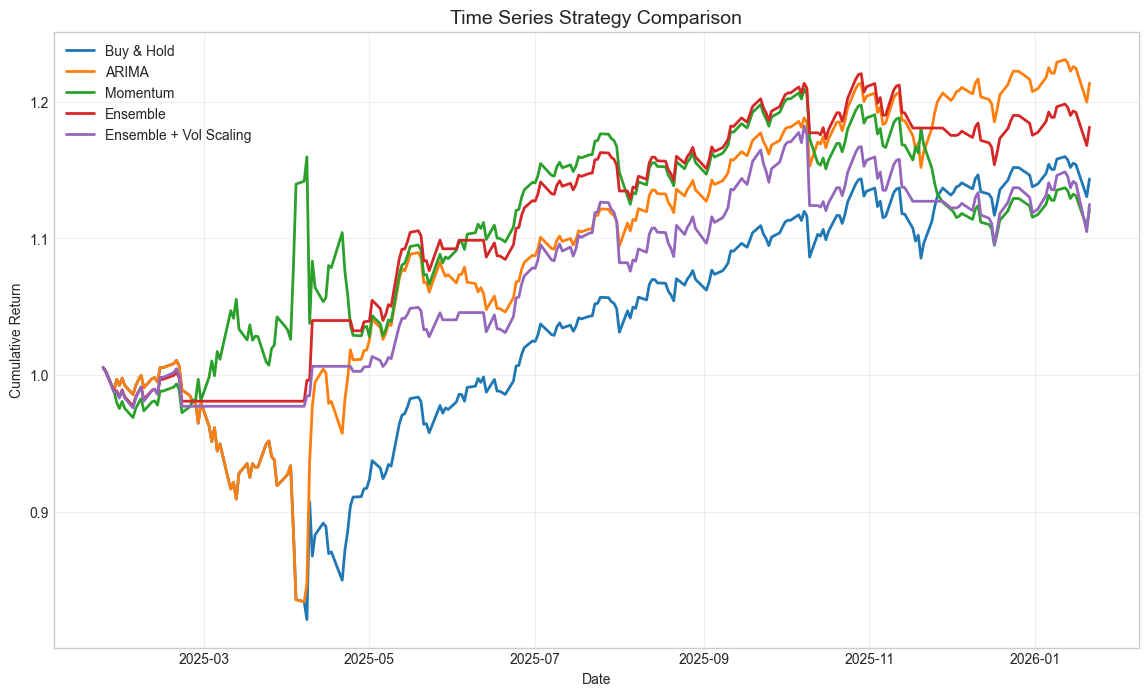

In [19]:
# Plot all strategies
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['arima_cum'], label='ARIMA', linewidth=2)
plt.plot(df.index, df['momentum_cum'], label='Momentum', linewidth=2)
plt.plot(df.index, df['ensemble_cum'], label='Ensemble', linewidth=2)
plt.plot(df.index, df['ensemble_vol_cum'], label='Ensemble + Vol Scaling', linewidth=2)
plt.title('Time Series Strategy Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Performance comparison
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    vol = returns.std() * np.sqrt(TRADING_DAYS)
    return total, sharpe, mdd, vol

print("\n" + "="*70)
print("STRATEGY COMPARISON")
print("="*70)

strategies = [
    ('Buy & Hold', df['actual'], df['buy_hold_cum']),
    ('ARIMA', df['arima_return'], df['arima_cum']),
    ('Momentum', df['momentum_return'], df['momentum_cum']),
    ('Ensemble', df['ensemble_return'], df['ensemble_cum']),
    ('Ensemble+Vol', df['ensemble_volscaled_return'], df['ensemble_vol_cum'])
]

print(f"\n{'Strategy':<15} {'Total Ret':>10} {'Sharpe':>8} {'Max DD':>10} {'Vol':>10}")
print("-" * 58)
for name, ret, cum in strategies:
    total, sharpe, mdd, vol = calc_metrics(ret, cum)
    print(f"{name:<15} {total:>10.2%} {sharpe:>8.2f} {mdd:>10.2%} {vol:>10.1%}")


STRATEGY COMPARISON

Strategy         Total Ret   Sharpe     Max DD        Vol
----------------------------------------------------------
Buy & Hold          14.35%     0.53    -18.76%      19.4%
ARIMA               21.34%     0.84    -17.46%      19.4%
Momentum            12.10%     0.43    -11.33%      19.4%
Ensemble            18.13%     1.14     -5.46%      10.8%
Ensemble+Vol        12.48%     0.64     -7.33%      11.9%


In [21]:
# Direction accuracy
print("\n" + "="*70)
print("DIRECTION ACCURACY")
print("="*70)

arima_acc = (np.sign(df['arima_pred']) == np.sign(df['actual'])).mean()
mom_acc = (np.sign(df['momentum_pred']) == np.sign(df['actual'])).mean()
ens_acc = (np.sign(df['ensemble_signal'].shift(1)) == np.sign(df['actual'])).mean()

print(f"\nARIMA: {arima_acc:.1%}")
print(f"Momentum: {mom_acc:.1%}")
print(f"Ensemble: {ens_acc:.1%}")


DIRECTION ACCURACY

ARIMA: 55.6%
Momentum: 57.2%
Ensemble: 39.6%


In [22]:
# Current predictions
print("\n" + "="*70)
print(f"📊 TODAY'S TRADING SIGNAL FOR {ticker}")
print("="*70)
print(f"\nDate: {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Current Price: ${float(prices.iloc[-1]):.2f}")

# Fresh predictions for latest data
arima_model = ARIMA(returns, order=(1, 0, 1))
arima_fit = arima_model.fit()
arima_next = arima_fit.forecast(steps=1).iloc[0]

garch_model = arch_model(returns * 100, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
garch_forecast = garch_fit.forecast(horizon=1)
garch_next_vol = np.sqrt(garch_forecast.variance.iloc[-1].values[0]) / 100

momentum_next = float(returns.rolling(momentum_window).mean().iloc[-1])

print(f"\nModel Predictions:")
print(f"  ARIMA: {arima_next:.4%} ({'📈' if arima_next > 0 else '📉'})")
print(f"  Momentum: {momentum_next:.4%} ({'📈' if momentum_next > 0 else '📉'})")
print(f"  GARCH Volatility: {garch_next_vol:.2%} daily")

# Ensemble
ensemble = np.sign(arima_next) + np.sign(momentum_next)
ensemble_signal = np.sign(ensemble) if ensemble != 0 else 0
target_vol_daily = 0.15 / np.sqrt(TRADING_DAYS)
position = np.clip(target_vol_daily / garch_next_vol, 0.5, 2) if garch_next_vol > 0 else 1

print(f"\n🎯 ENSEMBLE SIGNAL:")
signal_str = '📈 LONG' if ensemble_signal > 0 else '📉 SHORT' if ensemble_signal < 0 else '⏸️ NEUTRAL'
print(f"  Direction: {signal_str}")
print(f"  Position Size: {position:.2f}x")


📊 TODAY'S TRADING SIGNAL FOR SPY

Date: 2026-01-21
Current Price: $685.40

Model Predictions:
  ARIMA: 0.0638% (📈)
  Momentum: 0.0374% (📈)
  GARCH Volatility: 0.96% daily

🎯 ENSEMBLE SIGNAL:
  Direction: 📈 LONG
  Position Size: 0.99x


---

## 🏢 Interview Questions

### Q1: When to use each time series model?
| Model | Use Case |
|-------|----------|
| ARIMA | Return prediction, baseline |
| GARCH | Volatility forecasting, VaR |
| VAR | Cross-asset relationships |
| Cointegration | Pairs trading |
| Kalman | Dynamic parameters |
| Markov | Regime detection |

### Q2: Why combine models?
- Diversification of model risk
- Different information captured
- Reduced overfitting

### Q3: Key assumptions?
- ARIMA: Stationarity
- GARCH: Volatility clustering
- Cointegration: Long-run equilibrium

---
## 📅 Next Week: Feature Engineering